# Airbnb dataset

![](https://www.digital.ink/wp-content/uploads/airbnb_logo_detail.jpg)

### Description:
In this project, the popularity of an Airbnb posting is being measured using the 'reviews_per_month' variable as a proxy, although it's important to note that this may not be the most accurate measure as not all guests may leave a review after their stay. Nonetheless, this is being treated as a fun project and the approach is considered valid. The project involves testing and evaluating two models: a simple Linear Regression model, which will be used as a baseline for future models, and a tree boosting based model (XGB)

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
#import xgboost as xgb
import random
import json
import os
import functools
import re
import eli5

from matplotlib import pyplot as plt
from geopy.distance import geodesic 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, normalize, scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from plotly import express as px

## 1-Data Preparation

In [3]:
db = pd.read_csv('Airbnb_NYC.csv')

In [4]:
db.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
db_subs = db[['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']]
db_subs

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [6]:
db_subs.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [7]:
print(f"Number of data rows: {db_subs.count()[0]}")

Number of data rows: 48895


#### 1.1-Data Cleaning

In [8]:
#NaN data in reviews_per_monyh column
db_subs[db_subs['reviews_per_month'].isna()] = 0

In [9]:
#Removing empty data records
db_subs = db_subs[db_subs['room_type'] != 0]

In [10]:
print(f"Number of data rows after cleaning: {db_subs.count()[0]}")

Number of data rows after cleaning: 38843


        Prices Analysis

C:\Users\DELL\AppData\Local\Temp\ipykernel_15884\3888255174.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(db_subs['price'], kde=True, ax=ax[0])
C:\Users\DELL\AppData\Local\Temp\ipykernel_15884\3888255174.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(db_subs[db_subs['price'] < 800]['p

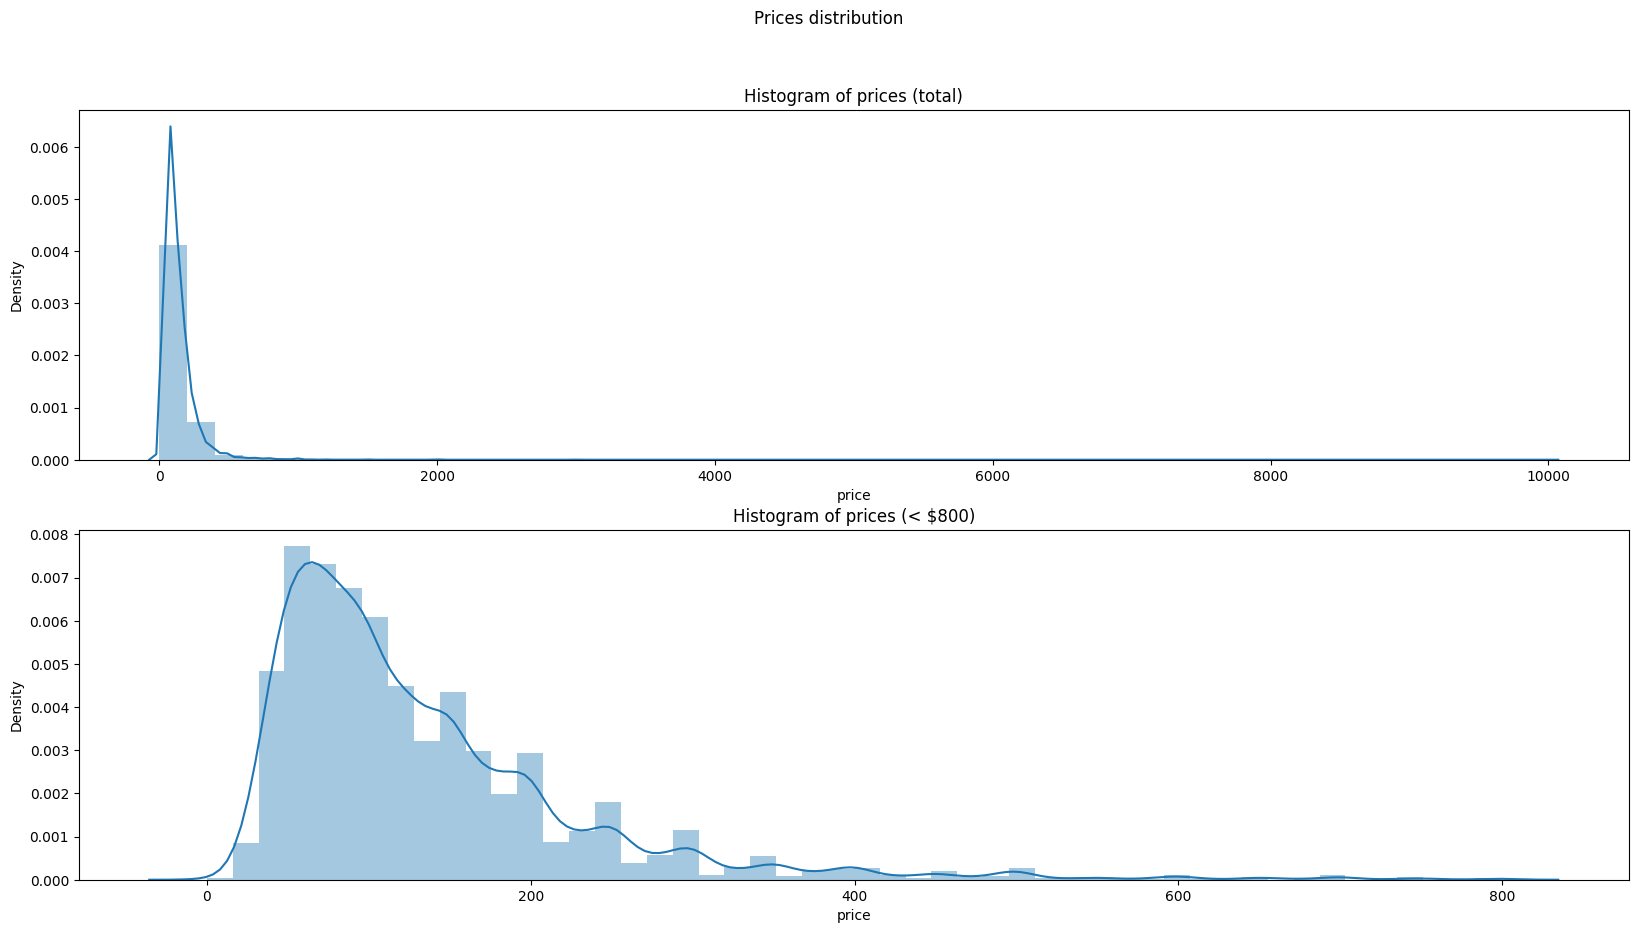

In [11]:
#Distribution
fig, ax= plt.subplots(2,1, figsize=(20,10))

ax[0].set_title("Histogram of prices (total)")
sns.distplot(db_subs['price'], kde=True, ax=ax[0])
ax[1].set_title("Histogram of prices (< $800)")
sns.distplot(db_subs[db_subs['price'] < 800]['price'], kde=True, ax=ax[1])



fig.suptitle("Prices distribution")
fig.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

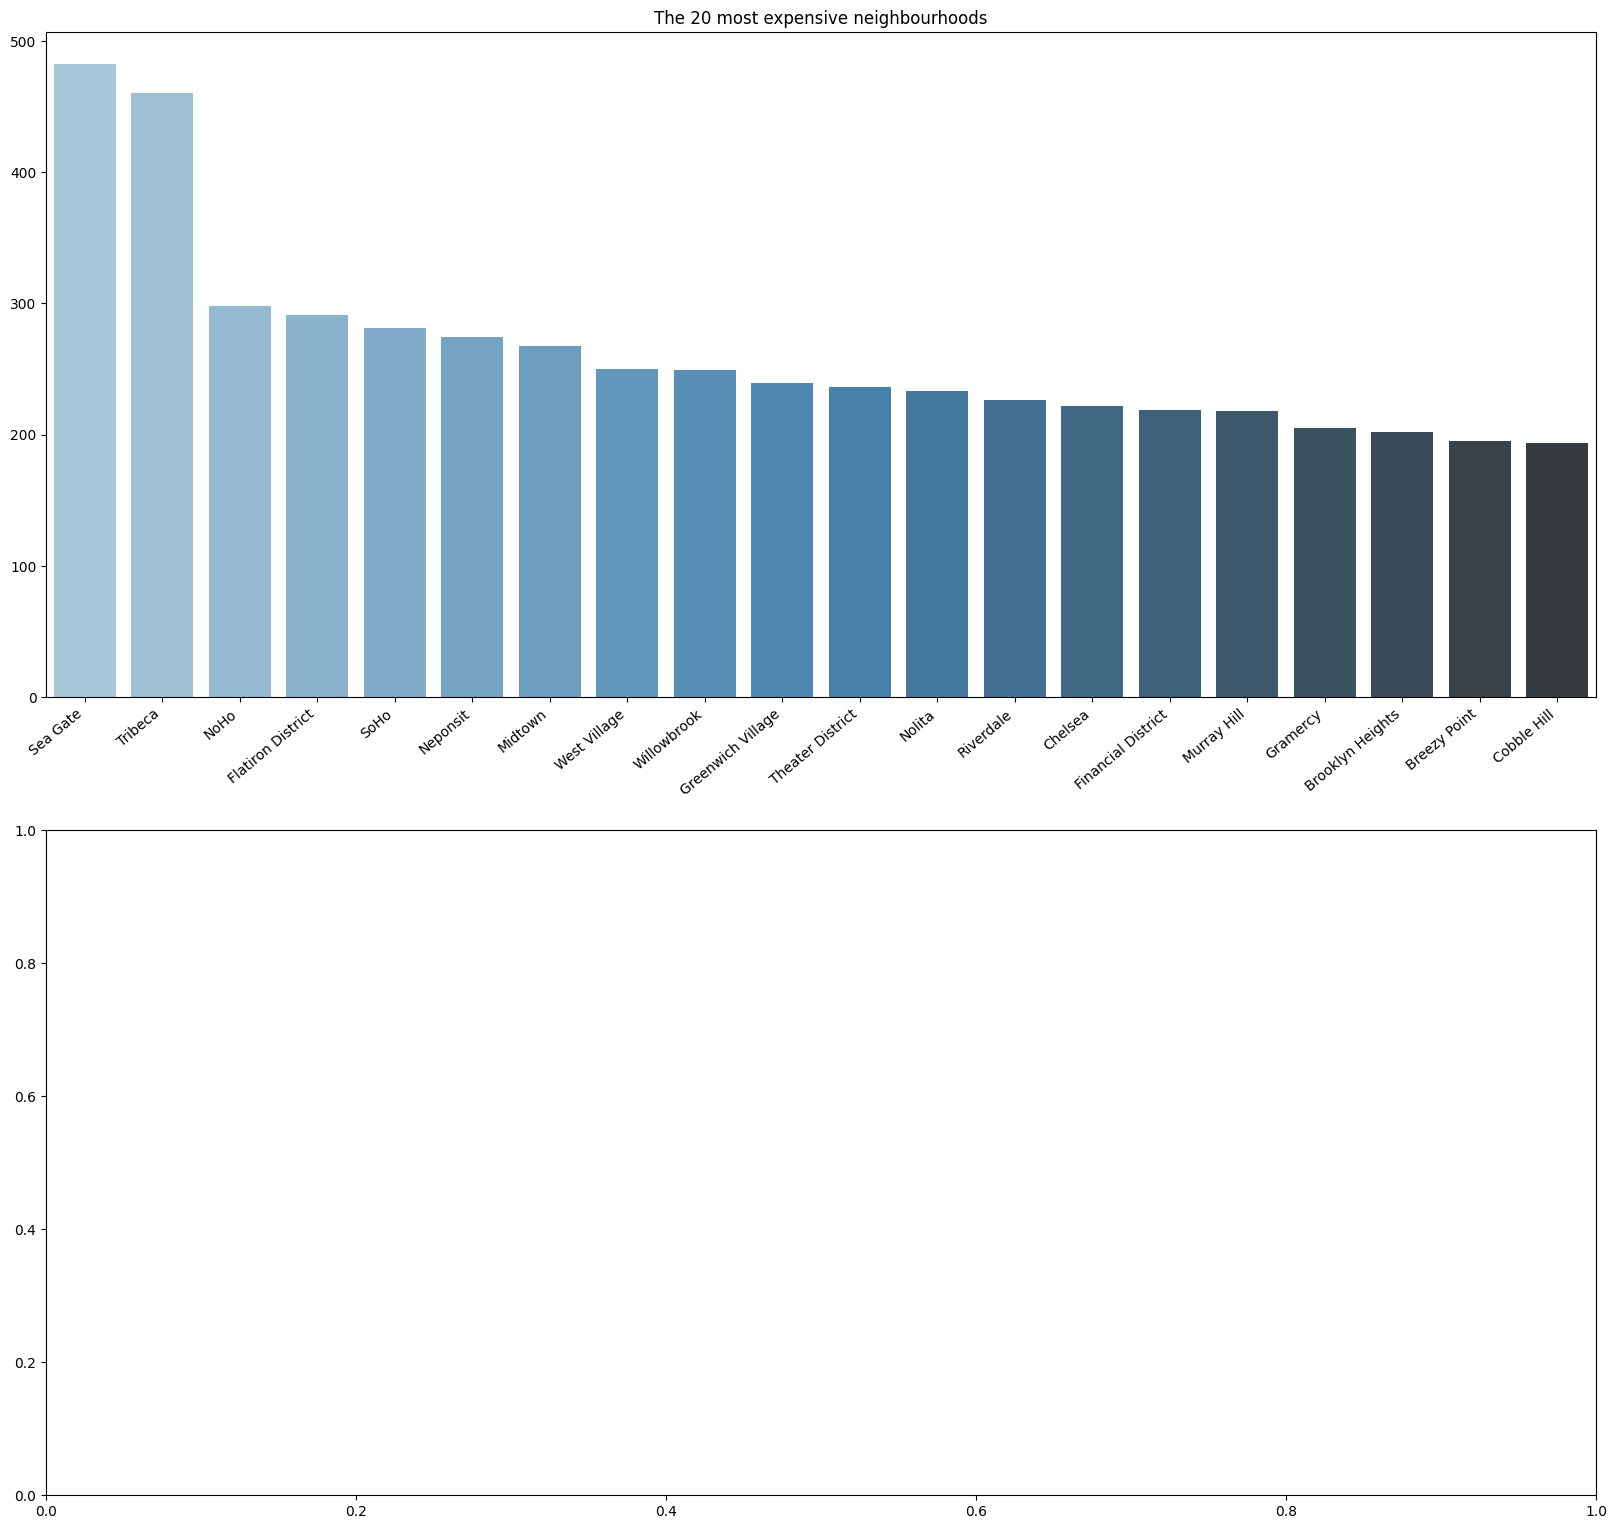

In [13]:
#Most expensive zones (spatial distriution)
d = db_subs.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

fig, ax= plt.subplots(2,1, figsize=(20,19))
sns.barplot(x=d.index.tolist()[:20], y=d.values[:20], ax=ax[0], palette=("Blues_d"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('The 20 most expensive neighbourhoods')

d = db_subs.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)[:5]
sns.barplot(d.index.tolist(), d.values, ax=ax[1], palette=("Blues_d"))
ax[1].set_title('Mean price per neighbourhood')

fig.show()

-> The price distribution here shows that most of the prices are under 700$

Visualizing the same results but on a map this time

In [ ]:
# a list of lists containing color values and their corresponding
# positions on a gradient scale. The first item in each sublist is a 
# float value between 0 and 1 representing the position of the color 
# on the gradient scale, while the second item is a string representing 
# the color in RGB format from red to purple 
cscale = [
          [0.0, 'rgb(165,0,38)'], 
          [0.0005, 'rgb(215,48,39)'], 
          [0.007, 'rgb(250, 152, 122)'], 
          [0.08, 'rgb(208, 254, 144)'], 
          [0.1, 'rgb(0, 255, 179)'], 
          [0.3, 'rgb(171,217,233)'], 
          [0.7, 'rgb(116,173,209)'], 
          [0.9, 'rgb(69,117,180)'], 
          [1.0, 'rgb(49,54,149)']
         ]

The colors grading is going to be done according to the pricing

In [ ]:
#plotting according to price distribution results
fig = px.scatter_mapbox(db_subs, lat="latitude", lon="longitude",  color="price", size="reviews_per_month",
                  color_continuous_scale=cscale, size_max=20, height=760, zoom=10, title='Map of NYC Airbnb rooms with price <= $700', range_color=(0,700))
fig.show()


NameError: name 'px' is not defined